# 과제 9
p141의 wine_data를 이용하여 logistic, SVM, CART 모형을 적합하되 **nested cross validation**을 적용하여 최선의 모형을 산출하라.

In [90]:
import pandas as pd
import numpy as np

# 데이터 불러오기. y값은 이미 범주형으로 되어있음.
dat_wine=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                     'wine/wine.data',header=None)
dat_wine.head()
dat_wine.columns = ['class label', 'alchohol', 'malic acid', 'ash', 
                    'alcalinity of ash', 'magnesium', 'total phenols', 
                    'flavanoids', 'nonflavanoid phenols', 
                    'proanthocyanins', 'color intensity', 'hue', 
                    'OD208', 'proline']  # Column names
print('class label:', np.unique(dat_wine['class label']))  # Class 출력
dat_wine.head()

class label: [1 2 3]


,class label,alchohol,malic acid,ash,alcalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD208,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [91]:
from sklearn.model_selection import train_test_split
X, y = dat_wine.iloc[:,1:].values, dat_wine.iloc[:,0].values
print(X.shape, y.shape)

(178, 13) (178,)


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(142, 13) (36, 13)


In [93]:
# 표준화를 안했더니 성능이 떡락 이어서 매우 당황한 상태이다........
# from sklearn.preprocessing import StandardScaler
# std = StandardScaler()
# X_train = std.fit_transform(X_train)
# X_test = std.transform(X_test)

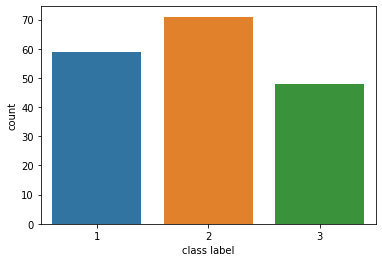

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=dat_wine, x='class label')

In [95]:
dat_wine['class label'].value_counts()/len(dat_wine)
# 비율은 그리 차이나지 않는다. 굳이 계층 추출을 하지 않아도 될듯?

2    0.398876
1    0.331461
3    0.269663
Name: class label, dtype: float64

In [96]:
# library import
from sklearn.pipeline import make_pipeline
import scipy as sp
import warnings
warnings.filterwarnings(action='ignore')

# About cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## baseline


In [110]:
model = SVC()
model.fit(X_train, y_train)
print('SVC score : %s' % model.score(X_test, y_test))

model = LogisticRegression()
model.fit(X_train, y_train)
print('Logistic score : %s' % model.score(X_test, y_test))

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print('DT score : %s' % model.score(X_test, y_test))

SVC score : 0.5833333333333334
Logistic score : 0.9166666666666666
DT score : 0.9444444444444444


## Nested CV로 Best model선택


In [66]:
# model별 param grid 설정
logit_params = {'penalty': ['l2', 'l1', 'elasticnet', None],
                'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20], 
                'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'multi_class':['auto', 'ovr', 'multinomial'],
}

svc_params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20, 100], 
              'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20, 100]
             }

tree_params = {'criterion':['gini', 'entropy'],
               'splitter':['best', 'random'], 
               'max_depth' :list((range(0, 15))), 
               'min_samples_leaf' :list((range(0, 10))), 
               'max_features' : ['auto', 'sqrt', 'log2', None],
               'ccp_alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20], 
                }

In [67]:
# 10*5 nested cross validation
inner_cv = KFold(n_splits = 5, shuffle=True, random_state=0) # 초모수 세팅
outer_cv = KFold(n_splits = 10, shuffle=True, random_state=0) # 성능 평가

In [68]:
%%time
gs_l = GridSearchCV(estimator=LogisticRegression(random_state=1), 
                  param_grid=logit_params,
                  scoring='accuracy', cv=inner_cv, n_jobs=-1)
scores_l = cross_val_score(gs_l, X, y, scoring='accuracy', cv=outer_cv)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_l), np.std(scores_l)))

CV accuracy: 0.949 +/- 0.046
CPU times: user 20.3 s, sys: 256 ms, total: 20.6 s
Wall time: 2min 15s


In [69]:
%%time
gs_s = GridSearchCV(estimator=SVC(random_state=1), 
                  param_grid=svc_params,
                  scoring='accuracy', cv=inner_cv, n_jobs=-1)
scores_s = cross_val_score(gs_s, X, y, scoring='accuracy', cv=outer_cv, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_s), np.std(scores_s)))

CV accuracy: 0.961 +/- 0.036
CPU times: user 49.5 ms, sys: 1.45 ms, total: 50.9 ms
Wall time: 6min 11s


In [70]:
%%time
gs_t = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid=tree_params,
                  scoring='accuracy', cv=inner_cv, n_jobs=-1)
scores_t = cross_val_score(gs_t, X, y, scoring='accuracy', cv=outer_cv, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_t), np.std(scores_t)))

CV accuracy: 0.905 +/- 0.070
CPU times: user 69.7 ms, sys: 3.81 ms, total: 73.5 ms
Wall time: 14min 7s


In [71]:
# svc가 최선의 모형임 > 다시 grid search
gs_s = GridSearchCV(estimator=SVC(random_state=1), 
                  param_grid=svc_params,
                  scoring='accuracy', cv=inner_cv, n_jobs=-1)
gs_s.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20,
                                   100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [73]:
print(gs_s.best_params_)
print(gs_s.best_score_)

{'C': 0.0001, 'gamma': 0.001, 'kernel': 'poly'}
0.9509852216748769


In [ ]:
C=1e-06, coef0=1,decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, random_state=1

## train size에 따른 편향과 분산 변화


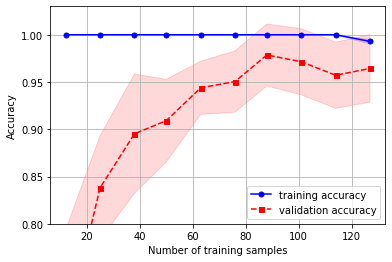

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
             learning_curve(estimator=SVC(C=1e-06, break_ties=False, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False), X=X_train, y=y_train,
                            train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
             
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='red', linestyle='--', marker='s',
         markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='red')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

[]

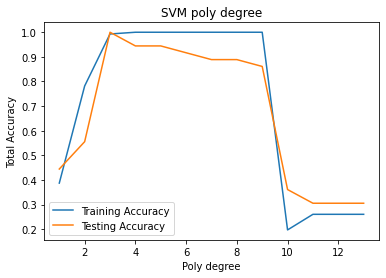

In [89]:

import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

c_list = [1,2,3,4,5,6,7,8,9,10,11,12,13]

train_errors = [] 
test_errors = [] 

for x in c_list:
    model= SVC(C=1e-06, break_ties=False, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=x, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    
    train_errors.append(accuracy_score(y_train, train_pred))
    test_errors.append(accuracy_score(y_test, pred))

x = np.arange(len(c_list)) + 1 # Create domain for plot
plt.plot(x, train_errors, label='Training Accuracy') # Plot training error over domain
plt.plot(x, test_errors, label='Testing Accuracy') # Plot testing error over domain
plt.xlabel('Poly degree') # Label x-axis
plt.ylabel('Total Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.title('SVM poly degree')
plt.plot() # Show graph